In [53]:
import xarray as xr
import xesmf as xe
import numpy as np

def preprocess(ds, lat_min=-90, lat_max=-55):
    '''This function preprocesses the individually opened
    MAR files and reduces it to areas where CALIOP can
    observe blowing snow.'''
    ds = ds.sel(lat=(slice(lat_min, lat_max)))
    
    return ds
    

ds = xr.open_mfdataset('/home/sh16450/caliop_blowing_snow/CAL_LID_L2_BlowingSnow_Antarctica-Standard-V1-00.*.nc', preprocess=preprocess)
# Load all the MAR data
MAR = xr.open_dataset('/home/sh16450/code/daily-CC-MAR_ERA5-2007-2016.nc')
MAR = MAR.groupby('TIME.month').mean()
MAR_grid = xr.open_dataset(
    '/home/sh16450/code/MARcst-AN35km-176x148.cdf')

monthly_mean_bs_sat = ds.groupby('time.month').mean()
annual_mean_bs_sat = ds.mean(dim='time')




# monthly_mean_bs_sat['bs_freq'].isel(month=5).plot()



In [60]:

ds_grid = xr.Dataset({'RIGNOT': (['Y', 'X'], MAR_grid.RIGNOT.values),
                      'SH': (['Y', 'X'], MAR_grid.SH.values),
                      'LAT': (['Y', 'X'], MAR_grid.LAT.values),
                      'LON': (['Y', 'X'], MAR_grid.LON.values)},
                     coords={'X': (['X'], MAR.X.values),
                             'Y': (['Y'], MAR.Y.values)})

# MAR_grid.drop(['X', 'Y'])

# Add LAT LON to MAR data
MAR['lat'] = ds_grid.LAT
MAR['lon'] = ds_grid.LON
MAR['RIGNOT'] = ds_grid.RIGNOT.where(ds_grid.RIGNOT > 0)
# MAR = MAR.drop_vars(['TIME_bnds'])
# MAR = MAR.rename({'TIME': 'time'})


In [68]:
ds

<xarray.Dataset>
Dimensions:  (time: 168, lat: 35, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
  * time     (time) datetime64[ns] 2006-06-01 2006-07-01 ... 2020-06-01
Data variables:
    bs_freq  (time, lat, lon) float64 dask.array<chunksize=(1, 35, 360), meta=np.ndarray>

In [62]:
# ==============================================================================
# Regridding operations
# ==============================================================================
# This creates the output grid, atm I think can be done with any variable
# as long as lat lon grid is present
ds_out = MAR
# Can be any MAR input grid as long as lat lon is present (rename!)
# REGRID MAR
ds_in = monthly_mean_bs_sat
regridder_MAR = xe.Regridder(ds_in, ds_out, 'bilinear')
regridder_MAR_lin = xe.Regridder(ds_in, ds_out, 'nearest_s2d')

regrid_sat = regridder_MAR(ds_in)




In [69]:
regrid_sat.to_netcdf('/home/sh16450/caliop_blowing_snow/ON_MAR_GRID-CAL_LID_L2_BlowingSnow_Antarctica-Standard-V1-00-2006-06-2020-06_monthly_means.nc')

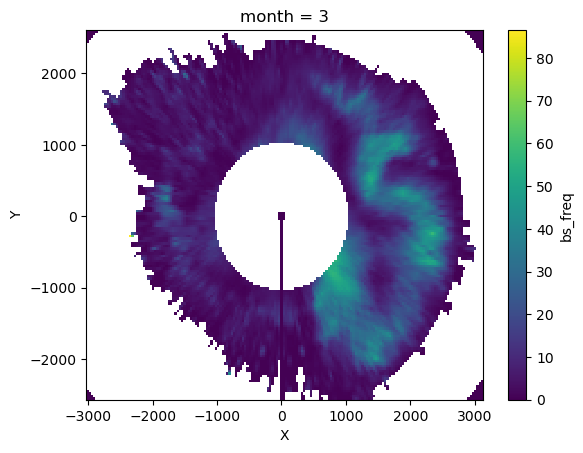

In [67]:
regrid_sat['bs_freq'].isel(month=2).plot()